In [408]:
import pandas as pd
import numpy as np
import boto3
import dotenv
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import papermill as pm

from geopy.distance import geodesic

aws_access_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_access_key = os.getenv("AWS_SECRET_ACCESS_KEY")
region = os.getenv("AWS_DEFAULT_REGION")
bucket = os.getenv("AWS_S3_BUCKET")

In [409]:
print("Bucket utilisé :", bucket)
print("Clé AWS présente :", aws_access_key_id is not None)

Bucket utilisé : projet-incendie
Clé AWS présente : True


In [410]:
pd.set_option('display.max_columns', None)
path = 13
df=pd.read_csv(f"output/{path}_Dataset_modele.csv", sep=';', encoding='utf-8')
df.head()    

C:\Users\m_bar\AppData\Local\Temp\ipykernel_151572\82180136.py:3: DtypeWarning: Columns (36,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(f"output/{path}_Dataset_modele.csv", sep=';', encoding='utf-8')


,POSTE,Date,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal,ville,geo_point_2d,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Département,Code INSEE_y,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux
0,13001009.0,2006-01-01,0.2,NaN,3.7,823.0,10.2,1413.0,6.1,6.95,0.4,NaN,6.5,7.0,1.7,13.4,330.0,1157.0,6.3,320.0,1220.0,NaN,NaN,50.0,1432.0,98.0,7.0,0.0,1028.0,7.9,85.0,NaN,NaN,0.7,0.8,13001.0,13080/13090/13100/13290/13540,Aix-En-Provence,"43.53607083783732, 5.398574445818331",0.51,0.61,2.05,0.96,NaN,1.94,5.19,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,13004003.0,2006-01-01,0.0,NaN,2.0,659.0,10.8,1327.0,7.1,6.40,-0.7,NaN,8.8,6.4,4.9,12.1,270.0,2150.0,8.5,280.0,1052.0,NaN,NaN,56.0,1314.0,98.0,3.0,0.0,583.0,7.8,78.0,NaN,NaN,1.0,1.0,13004.0,13200,Arles,"43.5468692377618, 4.6621564257363985",1.38,2.24,NaN,NaN,NaN,3.65,7.41,7.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,13005003.0,2006-01-01,0.0,NaN,4.8,745.0,10.8,1415.0,7.8,7.80,2.0,NaN,6.0,7.8,3.9,16.0,340.0,1145.0,8.0,340.0,1130.0,NaN,NaN,51.0,1400.0,97.0,200.0,0.0,581.0,7.8,75.0,NaN,NaN,NaN,1.3,13005.0,13400,Aubagne,"43.29348437640274, 5.563312734769378",1.52,0.85,NaN,NaN,3.65,3.55,7.17,8.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,13022003.0,2006-01-01,0.0,NaN,5.2,804.0,9.9,1353.0,7.6,7.55,NaN,NaN,4.7,7.6,5.9,17.4,320.0,1205.0,10.0,320.0,1053.0,NaN,NaN,54.0,1354.0,92.0,215.0,0.0,493.0,7.8,75.0,NaN,NaN,NaN,1.4,13022.0,13260,Cassis,"43.223047006454145, 5.551178109907389",NaN,NaN,NaN,NaN,NaN,5.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,13030001.0,2006-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030.0,13780,Cuges-Les-Pins,"43.28057170429038, 5.71024615752666",1.50,0.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [411]:
# Changement de type de la colonne Feux
df['Feux'] = df['Feux'].astype(int)

In [412]:
# Changement d'emplacement de la colonne Date
cols = [col for col in df.columns if col != 'Date']
cols.append('Date')
df = df[cols]

In [413]:
pd.set_option('display.max_rows', None)
df.isna().sum()/len(df)*100

POSTE                                           3.547766
RR                                              8.664697
DRR                                            94.382872
TN                                             19.783988
HTN                                            21.563921
TX                                             19.772895
HTX                                            21.538710
TM                                             21.374331
TMNX                                           19.787013
TNSOL                                          64.903541
TN50                                          100.000000
TAMPLI                                         19.787013
TNTXM                                          19.787013
FFM                                            30.284083
FXI                                            30.297193
DXI                                            30.419217
HXI                                            30.423251
FXY                            

In [414]:
# Vérification du nombre de feux
df['Feux'].value_counts()

Feux
0    95123
1     4038
Name: count, dtype: int64

In [415]:
mask = df['Feux'] == 1
df_feux = df[mask]
df_feux.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4038 entries, 67 to 95841
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   POSTE                                       520 non-null    float64
 1   RR                                          325 non-null    float64
 2   DRR                                         13 non-null     float64
 3   TN                                          233 non-null    float64
 4   HTN                                         223 non-null    float64
 5   TX                                          233 non-null    float64
 6   HTX                                         223 non-null    float64
 7   TM                                          223 non-null    float64
 8   TMNX                                        233 non-null    float64
 9   TNSOL                                       100 non-null    float64
 10  TN50           

In [416]:
df_feux.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4038 entries, 67 to 95841
Data columns (total 64 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   POSTE                                       520 non-null    float64
 1   RR                                          325 non-null    float64
 2   DRR                                         13 non-null     float64
 3   TN                                          233 non-null    float64
 4   HTN                                         223 non-null    float64
 5   TX                                          233 non-null    float64
 6   HTX                                         223 non-null    float64
 7   TM                                          223 non-null    float64
 8   TMNX                                        233 non-null    float64
 9   TNSOL                                       100 non-null    float64
 10  TN50           

In [417]:
# Mise en place de la colonne décompte avant le feu suivant

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ville', 'Date'])

def days_until_next_fire(group):
    # Dates où il y a un feu, sinon NaT
    feu_dates = group['Date'].where(group['Feux'] == 1)

    # On inverse la série pour faire un forward fill à rebours (pour chaque date, la prochaine date feu)
    next_feu_dates = feu_dates[::-1].ffill()[::-1]

    # Calcul du delta en jours entre la prochaine date feu et la date actuelle
    delta_days = (next_feu_dates - group['Date']).dt.days

    # Pour les lignes où Feux==1, mettre 0 (par sécurité)
    delta_days[group['Feux'] == 1] = 0

    return delta_days

df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)

print(df[['ville', 'Date', 'Feux', 'décompte']].head(100))

                ville       Date  Feux  décompte
0     Aix-En-Provence 2006-01-01     0       NaN
14    Aix-En-Provence 2006-01-02     0       NaN
28    Aix-En-Provence 2006-01-03     0       NaN
42    Aix-En-Provence 2006-01-04     0       NaN
56    Aix-En-Provence 2006-01-05     0       NaN
71    Aix-En-Provence 2006-01-06     0       NaN
85    Aix-En-Provence 2006-01-07     0       NaN
99    Aix-En-Provence 2006-01-08     0       NaN
113   Aix-En-Provence 2006-01-09     0       NaN
127   Aix-En-Provence 2006-01-10     0       NaN
141   Aix-En-Provence 2006-01-11     0       NaN
155   Aix-En-Provence 2006-01-12     0       NaN
169   Aix-En-Provence 2006-01-13     0       NaN
183   Aix-En-Provence 2006-01-14     0       NaN
197   Aix-En-Provence 2006-01-15     0       NaN
211   Aix-En-Provence 2006-01-16     0       NaN
225   Aix-En-Provence 2006-01-17     0       NaN
239   Aix-En-Provence 2006-01-18     0       NaN
253   Aix-En-Provence 2006-01-19     0       NaN
267   Aix-En-Provenc

C:\Users\m_bar\AppData\Local\Temp\ipykernel_151572\3312941464.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['décompte'] = df.groupby('ville').apply(days_until_next_fire).reset_index(level=0, drop=True)


In [418]:
# Modification de l'emplacement du nom de la commune dans le dataset pour plus de lisibilité

cols = list(df.columns)
cols.remove('ville')
new_position = len(cols) - 2
cols.insert(new_position, 'ville')

df = df[cols]


In [419]:
# df.drop(columns=['POSTE', 'Code INSEE_y', 'Commune', 'Département', 'latitude', 'longitude'], inplace=True)
df.head()

,POSTE,RR,DRR,TN,HTN,TX,HTX,TM,TMNX,TNSOL,TN50,TAMPLI,TNTXM,FFM,FXI,DXI,HXI,FXY,DXY,HXY,FXI3S,HXI3S,UN,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ORAG,BRUME,ETPMON,ETPGRILLE,Code INSEE_x,Code Postal,geo_point_2d,moyenne precipitations année,moyenne precipitations mois,moyenne evapotranspiration année,moyenne evapotranspiration mois,moyenne vitesse vent année,moyenne vitesse vent mois,moyenne temperature année,moyenne temperature mois,Département,Code INSEE_y,latitude,longitude,Surface parcourue (m2),Surface forêt (m2),Surface maquis garrigues (m2),Autres surfaces naturelles hors forêt (m2),Surfaces agricoles (m2),Autres surfaces (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2),Type de peuplement,Nature,Feux,ville,Date,décompte
0,13001009.0,0.2,NaN,3.7,823.0,10.2,1413.0,6.1,6.95,0.4,NaN,6.5,7.0,1.7,13.4,330.0,1157.0,6.3,320.0,1220.0,NaN,NaN,50.0,1432.0,98.0,7.0,0.0,1028.0,7.9,85.0,NaN,NaN,0.7,0.8,13001.0,13080/13090/13100/13290/13540,"43.53607083783732, 5.398574445818331",0.51,0.61,2.05,0.96,NaN,1.94,5.19,1.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Aix-En-Provence,2006-01-01,NaN
14,13001009.0,0.0,NaN,2.8,604.0,9.9,1331.0,4.8,6.35,-0.9,NaN,7.1,6.4,2.5,12.8,330.0,1105.0,6.7,330.0,1107.0,NaN,NaN,57.0,1408.0,97.0,2348.0,0.0,814.0,6.7,79.0,NaN,NaN,1.2,1.2,13001.0,13080/13090/13100/13290/13540,"43.53607083783732, 5.398574445818331",0.51,0.75,2.07,0.95,NaN,1.91,5.23,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Aix-En-Provence,2006-01-02,NaN
28,13001009.0,0.2,NaN,-2.6,610.0,10.1,1319.0,1.9,3.75,-7.2,NaN,12.7,3.8,0.8,6.4,330.0,1421.0,3.5,320.0,1430.0,NaN,NaN,39.0,1320.0,98.0,148.0,47.0,848.0,5.1,77.0,NaN,NaN,0.9,0.8,13001.0,13080/13090/13100/13290/13540,"43.53607083783732, 5.398574445818331",0.51,0.75,2.09,0.97,NaN,1.98,5.27,2.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Aix-En-Provence,2006-01-03,NaN
42,13001009.0,0.0,NaN,-3.8,704.0,10.2,1247.0,1.2,3.20,-8.2,NaN,14.0,3.2,0.8,5.2,20.0,926.0,2.6,260.0,1348.0,NaN,NaN,40.0,1227.0,95.0,2152.0,6.0,856.0,4.9,77.0,NaN,NaN,0.9,0.7,13001.0,13080/13090/13100/13290/13540,"43.53607083783732, 5.398574445818331",0.55,0.74,2.11,0.98,NaN,1.96,5.32,1.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Aix-En-Provence,2006-01-04,NaN
56,13001009.0,1.4,NaN,-3.4,223.0,6.2,2331.0,2.5,1.40,-7.6,NaN,9.6,1.4,1.2,9.8,110.0,2155.0,5.0,120.0,2157.0,NaN,NaN,69.0,2327.0,97.0,347.0,0.0,1212.0,6.4,87.0,NaN,NaN,0.1,0.1,13001.0,13080/13090/13100/13290/13540,"43.53607083783732, 5.398574445818331",0.55,0.74,2.12,0.98,NaN,1.92,5.36,1.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Aix-En-Provence,2006-01-05,NaN


### Traitement des latitudes et longitudes manquante

In [420]:
mask = df['latitude'].isna()
df_merge_nan = df[mask]


In [421]:
df_merge_nan.latitude.isna().sum()

95123

In [422]:
# export du fichier contenant les villes manquantes 
nombre_unique = df_merge_nan['ville']
nombre_unique.to_csv(f'output/{path}_nombre_unique')
# pm.execute_notebook(
#     'requete_gps_ville.ipynb',     # Notebook à exécuter
#     'notebook2_sortie.ipynb',         # Notebook de sortie généré (ou temporaire)
#     parameters=dict(fichier_csv=f"output/{path}_nombre_unique'")
# )

In [423]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

In [424]:
news_gps = pd.read_csv(f'output/{path}_new_gps.csv')
# on renomme la colonne qui va servir au merge
news_gps = news_gps.rename(columns={'properties.name':'ville'})
# on supprime les colonnes inutiles
news_gps = news_gps.drop(news_gps.columns[[0,1,3]], axis=1)
# Fusionner les deux DataFrames sur la colonne 'ville'
df_combined = df.merge(news_gps, on='ville', how='left', suffixes=('', '_y'))
# Remplacer les valeurs manquantes dans df1 par celles de df2
df_combined['latitude'] = df_combined['latitude_y'].combine_first(df_combined['latitude'])
df_combined['longitude'] = df_combined['longitude_y'].combine_first(df_combined['longitude'])
# Supprimer les colonnes supplémentaires créées par la fusion
df_combined = df_combined.drop(columns=['latitude_y', 'longitude_y'])
df_merge = df_combined
# il restait 256 lignes sans localisation gps que l'on supprime
df_merge= df_merge.dropna(subset=['latitude', 'longitude'])

In [425]:
df_merge.latitude.isna().sum()

0

In [ ]:
# suppression des latitudes et longitudes toujours en NaN
# df_merge= df_merge.dropna(subset=['latitude', 'longitude'])

### On complète certaines données météo en utilisant les données de la ville la plus proche

In [426]:
from geopy.distance import geodesic
import pandas as pd

# 🔹 Colonnes météo à compléter
colonnes_meteo = [
    'RR', 'TN', 'TX', 'FFM',
    'UM', 
]

# 🔹 Séparer les lignes avec et sans valeurs manquantes météo
df_manquantes = df_merge[df_merge[colonnes_meteo].isnull().any(axis=1)].copy()
df_completes = df_merge[df_merge[colonnes_meteo].notna().all(axis=1)].copy()

# 🔹 Fonction pour remplir les colonnes météo manquantes sans limite de distance
def recuperer_valeurs_manquantes(row, df_source):
    latitude, longitude = row['latitude'], row['longitude']
    if pd.isna(latitude) or pd.isna(longitude):
        return row  # Coordonnées manquantes, on ne modifie pas

    coord = (latitude, longitude)

    # Liste unique des villes avec leurs coordonnées
    
    villes_ref = df_source[['ville', 'latitude', 'longitude']].dropna().drop_duplicates()

    # Calculer les distances depuis la position courante
    distances = []
    for _, ref_row in villes_ref.iterrows():
        ville = ref_row['ville']
        ref_coord = (ref_row['latitude'], ref_row['longitude'])
        dist = geodesic(coord, ref_coord).km
        distances.append((ville, dist))

    # Trier toutes les villes par distance
    df_distances = pd.DataFrame(distances, columns=['ville', 'distance'])
    villes_ordre = df_distances.sort_values('distance')['ville'].tolist()

    # Copie de la ligne pour modification
    row_corrige = row.copy()

    for col in colonnes_meteo:
        if pd.isna(row[col]):
            for ville in villes_ordre:
                ligne_match = df_source[
                    (df_source['ville'] == ville) & (df_source['Date'] == row['Date'])
                ]
                if not ligne_match.empty:
                    valeur = ligne_match[col].iloc[0]
                    if pd.notna(valeur):
                        row_corrige[col] = valeur
                        break  # On arrête dès qu'on trouve une valeur

    return row_corrige

# 🔹 Application de la correction ligne par ligne
df_manquantes_corrigees = df_manquantes.apply(
    lambda row: recuperer_valeurs_manquantes(row, df_completes), axis=1
)

# 🔹 Fusion finale des données
df_final = pd.concat([df_completes, df_manquantes_corrigees])
df_final = df_final[df.columns]  # Respecte l’ordre original
df_final = df_final.sort_index()


In [ ]:

df_merge=df_final


# Creation de nouvelles colonnes pour le modèle survival 
### colonne Feu prévu
### compteur jour vers prochain feu
### compteur feu log
### compteur feu carré
### nombre de feu par an/ville
### nombre de feu par mois/ville
### nombre de jour sans pluie consécutif
### nombre de jour avec une t°c supérieur à 30°c consécutif
### évapotranspiration Potentielle journalière moyenne sur 7jrs

In [431]:
# Création de la colonne évènement pour indiquer si un feu a eu lieu
df_merge['évènement'] = df_merge['Feux'] == 1
# Création de la colone Feu prévu pour le modèle Survival
df_merge.loc[:, "Feu prévu"] = df["décompte"].notna().astype(int)
# S'assurer que la date est bien au bon format
df_merge["Date"] = pd.to_datetime(df_merge["Date"])

# Trier le DataFrame par ville et date
df_merge = df_merge.sort_values(by=["ville", "Date"]).reset_index(drop=True)

# Nouvelle colonne initialisée à NaN
df_merge["compteur jours vers prochain feu"] = pd.NA

# Traitement par ville
for ville, groupe in df_merge.groupby("ville"):
    groupe = groupe.sort_values("Date")
    indices_feux = groupe[groupe["évènement"] == True].index.tolist()
    
    for i in range(len(indices_feux) - 1):
        debut = indices_feux[i]
        fin = indices_feux[i + 1]
        
        # Remplir les jours entre les deux feux avec un compteur croissant
        for j, idx in enumerate(range(debut, fin)):
            df_merge.loc[idx, "compteur jours vers prochain feu"] = j
# # nombre de jour sans feu + log et carré

df_merge['compteur feu log'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: np.log1p(x) if pd.notnull(x) else np.nan)
df_merge['compteur feu carré'] = df_merge['compteur jours vers prochain feu'].apply(lambda x: x**2 if pd.notnull(x) else np.nan)



In [432]:
# # Calcule le nombre de feux par an et mois pour chaque ville
df_merge['Année'] = df_merge['Date'].dt.year
df_merge['Mois'] = df_merge['Date'].dt.month

df_merge['Nombre de feu par an'] = df_merge.groupby(['ville', 'Année'])['Feux'].transform('sum')
df_merge['Nombre de feu par mois'] = df_merge.groupby(['ville', 'Année', 'Mois'])['Feux'].transform('sum')

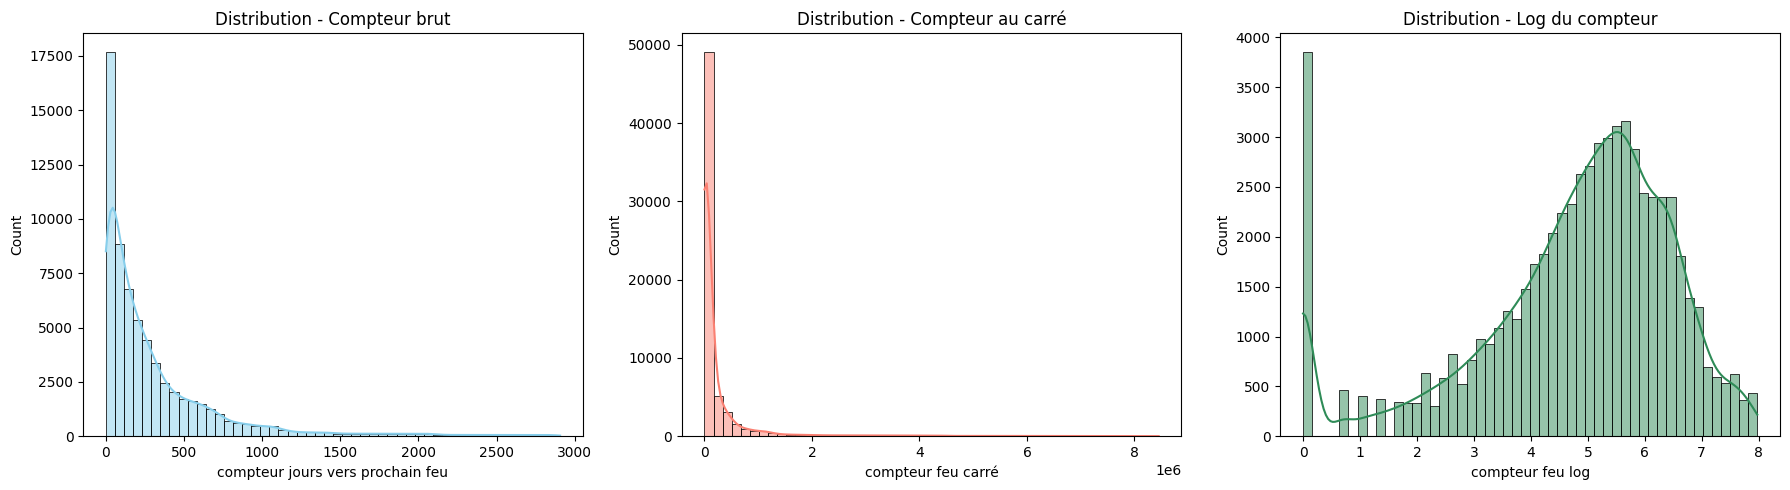

In [433]:
# visualisation
plt.figure(figsize=(18, 5))

# Distribution originale
plt.subplot(1, 3, 1)
sns.histplot(df_merge["compteur jours vers prochain feu"], bins=50, kde=True, color="skyblue")
plt.title("Distribution - Compteur brut")

# Carré
plt.subplot(1, 3, 2)
sns.histplot(df_merge["compteur feu carré"], bins=50, kde=True, color="salmon")
plt.title("Distribution - Compteur au carré")

# Logarithme
plt.subplot(1, 3, 3)
sns.histplot(df_merge["compteur feu log"], bins=50, kde=True, color="seagreen")
plt.title("Distribution - Log du compteur")

plt.tight_layout()
plt.show()

In [434]:

# Trier par ville et par date
df_merge = df_merge.sort_values(['ville', 'Date'])

# Fonction pour compter les jours consécutifs sans pluie
def compter_jours_sans_pluie(groupe):
    compteur = 0
    jours_sans_pluie = []
    for rr in groupe['RR']:
        if pd.isna(rr):
            jours_sans_pluie.append(np.nan)
        elif rr == 0:
            compteur += 1
            jours_sans_pluie.append(compteur)
        else:
            compteur = 0
            jours_sans_pluie.append(compteur)
    return jours_sans_pluie

# Appliquer par ville
df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values

C:\Users\m_bar\AppData\Local\Temp\ipykernel_151572\3432562024.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_sans_pluie'] = df_merge.groupby('ville').apply(compter_jours_sans_pluie).explode().astype(float).values


In [435]:

# Fonction pour compter les jours consécutifs avec TX > 30
def compter_jours_chauds(groupe):
    compteur = 0
    jours_chauds = []
    for tx in groupe['TX']:
        if pd.isna(tx):
            jours_chauds.append(np.nan)
        elif tx > 30:
            compteur += 1
            jours_chauds.append(compteur)
        else:
            compteur = 0
            jours_chauds.append(compteur)
    return jours_chauds

# Appliquer la fonction par ville
df_merge= df_merge.sort_values(['ville', 'Date'])  # Assurer l'ordre temporel
df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values

C:\Users\m_bar\AppData\Local\Temp\ipykernel_151572\2308045979.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merge['jours_TX_sup_30'] = df_merge.groupby('ville').apply(compter_jours_chauds).explode().astype(float).values


In [436]:
# Évapotranspiration Potentielle journalière moyenne sur 7jrs
df_merge["ETPGRILLE_7j"] = df_merge.groupby("ville")["ETPGRILLE"].transform(lambda x: x.rolling(7, min_periods=1).mean())


In [438]:
df_merge.to_csv(f'output/{path}_dataset_modele_full.csv', index=False, sep=';')

In [439]:
# print("Bucket utilisé :", bucket)
# s3 = boto3.client(
#     "s3",
#     aws_access_key_id=aws_access_key_id,
#     aws_secret_access_key=aws_secret_access_key,
#     region_name=region
# )
# s3.upload_file("dataset_modele_decompte.csv", bucket, "dataset_modele_decompte.csv")